In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from basis.src.basis import BasalIceStratigrapher
from basis.src.tvd_advection import AdvectTVD

In [2]:
# Initialize the model
BIS = BasalIceStratigrapher()
BIS.initialize('./experiments/static-effective-pressure/input_file.toml')

basal_water_pressure = 0.9 * (
    BIS.grid.at_node['ice_thickness'] * BIS.params['ice_density'] * BIS.params['gravity']
)
BIS.set_value('basal_water_pressure', basal_water_pressure)

BIS.set_value('sliding_velocity_y', BIS.grid.at_node['sliding_velocity_y'][:] * -1)

BIS.calc_effective_pressure()
BIS.calc_shear_stress()
BIS.calc_erosion_rate()
BIS.calc_melt_rate()

# Identify terminus nodes
dx = BIS.grid.dx
dy = BIS.grid.dy
bounds = [50 * dx, 100 * dx, 0 * dy, 15 * dy]
BIS.identify_terminus(bounds, depth = 3)

# Start with initial sediment package
initial_till = np.full(BIS.grid.number_of_nodes, 40)
BIS.set_value('till_thickness', initial_till)

initial_fringe = np.full(BIS.grid.number_of_nodes, 1e-3)
BIS.set_value('fringe_thickness', initial_fringe)

initial_dispersed = np.full(BIS.grid.number_of_nodes, 1e-9)
BIS.set_value('dispersed_layer_thickness', initial_dispersed)

In [3]:
# Spin-up the sediment entrainment module
for t in range(100):
    BIS.entrain_sediment(t * 1e-2)

for t in range(100):
    BIS.entrain_sediment(t)

for t in range(100):
    BIS.entrain_sediment(100)
    BIS.time_elapsed += 100

for t in range(2500):
    dt = BIS.sec_per_a / 100
    BIS.entrain_sediment(dt)
    BIS.time_elapsed += dt

    if t % 100 == 0:
        print('Completed step #' + str(t))

print('Completed spin-up: ' + str(np.round(BIS.time_elapsed / BIS.sec_per_a, 2)) + ' years elapsed.')

mask, Qf, Qd = BIS.calc_sediment_flux()
print('Qf = ' + str(Qf * 2700 / 1e3))
print('Qd = ' + str(Qd * 2700 / 1e3))

Completed step #0
Completed step #100
Completed step #200
Completed step #300
Completed step #400
Completed step #500
Completed step #600
Completed step #700
Completed step #800
Completed step #900
Completed step #1000
Completed step #1100
Completed step #1200
Completed step #1300
Completed step #1400
Completed step #1500
Completed step #1600
Completed step #1700
Completed step #1800
Completed step #1900
Completed step #2000
Completed step #2100
Completed step #2200
Completed step #2300
Completed step #2400
Completed spin-up: 25.0 years elapsed.
Qf = 21565.065445
Qd = 561.843588685


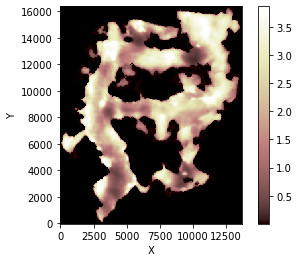

In [4]:
imshow_grid(BIS.grid, 'fringe_thickness')

Completed step 0
Maximum pointwise change = 0.568438292864 m.


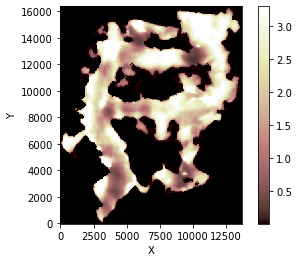

Completed step 100
Maximum pointwise change = 0.0198045584272 m.
Completed step 200
Maximum pointwise change = 0.00865855559599 m.
Completed step 300
Maximum pointwise change = 0.00600156285038 m.
Completed step 400
Maximum pointwise change = 0.00447617524151 m.
Completed step 500
Maximum pointwise change = 0.00543577084588 m.
Completed step 600
Maximum pointwise change = 0.00529661690237 m.
Completed step 700
Maximum pointwise change = 0.00448722929383 m.
Completed step 800
Maximum pointwise change = 0.00500025836937 m.
Completed step 900
Maximum pointwise change = 0.00544448342507 m.
Completed step 1000
Maximum pointwise change = 0.00586283740987 m.


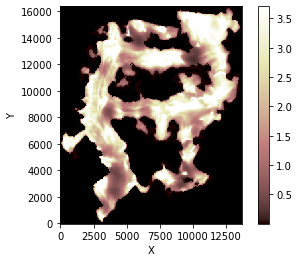

Completed step 1100
Maximum pointwise change = 0.00388421756824 m.
Completed step 1200
Maximum pointwise change = 0.0036804658574 m.
Completed step 1300
Maximum pointwise change = 0.00358657911163 m.
Completed step 1400
Maximum pointwise change = 0.00490587598113 m.
Completed step 1500
Maximum pointwise change = 0.00419967617947 m.
Completed step 1600
Maximum pointwise change = 0.00415574585744 m.
Completed step 1700
Maximum pointwise change = 0.00526813692143 m.
Completed step 1800
Maximum pointwise change = 0.00223860252733 m.
Completed step 1900
Maximum pointwise change = 0.00245964145398 m.
Completed step 2000
Maximum pointwise change = 0.00507313374121 m.


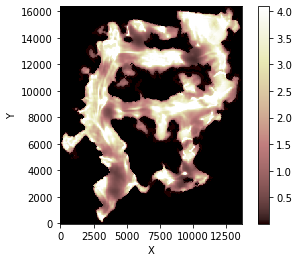

Completed step 2100
Maximum pointwise change = 0.00409442512572 m.
Completed step 2200
Maximum pointwise change = 0.00342173672866 m.
Completed step 2300
Maximum pointwise change = 0.00298131595745 m.
Completed step 2400
Maximum pointwise change = 0.00524452653134 m.
Completed step 2500
Maximum pointwise change = 0.00252085823295 m.
Completed step 2600
Maximum pointwise change = 0.00420063570803 m.
Completed step 2700
Maximum pointwise change = 0.00370183249636 m.
Completed step 2800
Maximum pointwise change = 0.00347495354019 m.
Completed step 2900
Maximum pointwise change = 0.00343771677816 m.
Completed step 3000
Maximum pointwise change = 0.0028866778907 m.


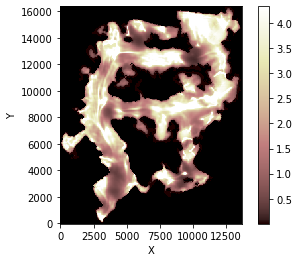

Completed step 3100
Maximum pointwise change = 0.00503447993441 m.
Completed step 3200
Maximum pointwise change = 0.00488137743327 m.
Completed step 3300
Maximum pointwise change = 0.00313616814024 m.
Completed step 3400
Maximum pointwise change = 0.00413954739907 m.
Completed step 3500
Maximum pointwise change = 0.00268304341523 m.
Completed step 3600
Maximum pointwise change = 0.00335869538312 m.
Completed step 3700
Maximum pointwise change = 0.00394835894301 m.
Completed step 3800
Maximum pointwise change = 0.00262200752254 m.
Completed step 3900
Maximum pointwise change = 0.00280679763051 m.
Completed step 4000
Maximum pointwise change = 0.00415253175953 m.


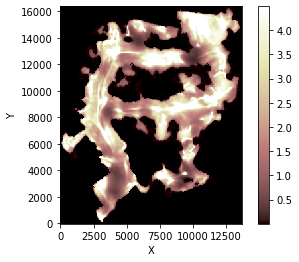

Completed step 4100
Maximum pointwise change = 0.00467819266138 m.
Completed step 4200
Maximum pointwise change = 0.00431955054115 m.
Completed step 4300
Maximum pointwise change = 0.00291319749477 m.
Completed step 4400
Maximum pointwise change = 0.0027516108779 m.
Completed step 4500
Maximum pointwise change = 0.00536842271465 m.
Completed step 4600
Maximum pointwise change = 0.00529309491655 m.
Completed step 4700
Maximum pointwise change = 0.00408711397621 m.
Completed step 4800
Maximum pointwise change = 0.00240349403239 m.
Completed step 4900
Maximum pointwise change = 0.00321284410754 m.
Completed step 5000
Maximum pointwise change = 0.00368589241002 m.


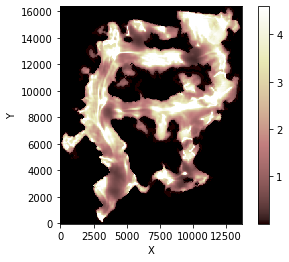

Completed step 5100
Maximum pointwise change = 0.00251171812672 m.
Completed step 5200
Maximum pointwise change = 0.00416045123373 m.


KeyboardInterrupt: 

In [11]:
init_fringe = BIS.grid.at_node['fringe_thickness'].copy()
init_dispersed = BIS.grid.at_node['dispersed_layer_thickness'].copy()

ux = BIS.grid.map_mean_of_link_nodes_to_link('sliding_velocity_x')
uy = BIS.grid.map_mean_of_link_nodes_to_link('sliding_velocity_y')

velocity = np.zeros(BIS.grid.number_of_links)

velocity = np.where(
    np.isin(np.arange(BIS.grid.number_of_links), BIS.grid.horizontal_links),
    ux,
    uy
)

BIS.grid.add_field('velocity_links', velocity, at = 'link', clobber = True)

dts = np.linspace(5e5, 5e6, 10)

for dt in dts:
    model = BasalIceStratigrapher()
    model.initialize('./experiments/static-effective-pressure/input_file.toml')

    basal_water_pressure = 0.9 * (
        model.grid.at_node['ice_thickness'] * model.params['ice_density'] * model.params['gravity']
    )
    model.set_value('basal_water_pressure', basal_water_pressure)

    model.set_value('sliding_velocity_y', model.grid.at_node['sliding_velocity_y'][:] * -1)

    model.calc_effective_pressure()
    model.calc_shear_stress()
    model.calc_erosion_rate()
    model.calc_melt_rate()

    # Identify terminus nodes
    dx = model.grid.dx
    dy = model.grid.dy
    bounds = [50 * dx, 100 * dx, 0 * dy, 15 * dy]
    model.identify_terminus(bounds)

    # Start with initial sediment package
    initial_till = np.full(model.grid.number_of_nodes, 40)
    model.set_value('till_thickness', initial_till)

    model.set_value('fringe_thickness', init_fringe)

    model.set_value('dispersed_layer_thickness', init_dispersed)
    
    model.grid.add_field('velocity_links', velocity, at = 'link', clobber = True)

    advector = AdvectTVD(model.grid, 'fringe_thickness', 'velocity_links')
    advect_disp = AdvectTVD(model.grid, 'dispersed_layer_thickness', 'velocity_links')
    
    test_courant = np.max(np.abs(advector.calc_courant(advector._grid, advector._vel, dt)))
    if test_courant > 1:
        print('Advection likely unstable under CFL condition.')
        
    end_year = 250
    n_steps = int(np.ceil(model.sec_per_a * end_year / dt))
    tolerance = 1e-8
    
    for i in range(n_steps):
        old_fringe = model.grid.at_node['fringe_thickness'].copy()
        
        advector.update(dt, clamp = 95)
        advect_disp.update(dt)
        model.entrain_sediment(dt)
        
        fringe = model.grid.at_node['fringe_thickness']
        cutoff = np.percentile(fringe, 95)
        fringe[:] = np.where(fringe > cutoff, cutoff, fringe)
        
        if i % 100 == 0:
            print('Completed step ' + str(i))
            print('Maximum pointwise change = ' + str(np.max(np.abs(fringe[:] - old_fringe))) + ' m.')
            
            if np.max(np.abs(fringe[:] - old_fringe)) < tolerance:
            print('Completed simulation, dt = ' + str(dt) + ' seconds.')
            
            diff = model.grid.at_node['fringe_thickness'][:] - init_fringe
            imshow_grid(model.grid, diff, cmap = 'RdBu')
            plt.show()
            break
            
        if i % 1000 == 0:
            imshow_grid(model.grid, 'fringe_thickness')
            plt.show()

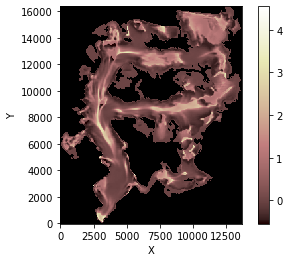

In [10]:
field = model.grid.at_node['fringe_thickness'] - init_fringe
imshow_grid(model.grid, field)

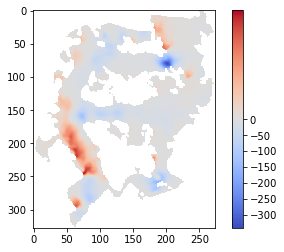

In [6]:
toplot = np.flip(np.reshape(np.where(BIS.grid.at_node['ice_thickness'] > 0.5, vel_nodes, np.nan), BIS.grid.shape), axis = 0)

im = plt.imshow(toplot, cmap = 'coolwarm',
           norm = TwoSlopeNorm(vmin = np.nanmin(toplot), vmax = np.nanmax(toplot), vcenter=0))
plt.colorbar(im)
plt.show()

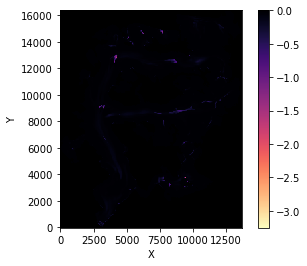

In [77]:
toplot = -model.grid.at_node['fringe_thickness_flux_div'] * model.sec_per_a

imshow_grid(
    BIS.grid, 
    toplot,
    cmap = 'magma_r',
    vmax = 0
)

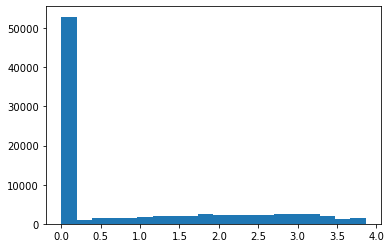

In [78]:
plt.hist(BIS.grid.at_node['fringe_thickness'][:], bins = 20)
plt.show()

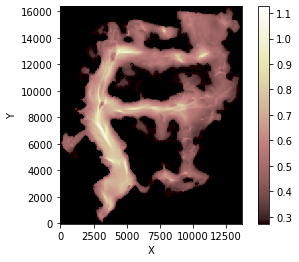

In [14]:
imshow_grid(BIS.grid, 'dispersed_layer_thickness')